|  ![Sunrise Boston Logo](https://github.com/edgi-govdata-archiving/EEW-Image-Assets/blob/master/sunrise%20boston.jpg?raw=true) | ![EEW logo](https://github.com/edgi-govdata-archiving/EEW-Image-Assets/blob/master/Jupyter%20instructions/eew.jpg?raw=true) | ![EDGI logo](https://github.com/edgi-govdata-archiving/EEW-Image-Assets/blob/master/Jupyter%20instructions/edgi.png?raw=true) |
|---|---|---|

#### This notebook is licensed under GPL 3.0. Please visit [our Github repo](https://github.com/edgi-govdata-archiving/ECHO-Sunrise) for more information.
#### The notebook was collaboratively authored by the Environmental Data & Governance Initiative (EDGI) following our [authorship protocol](https://docs.google.com/document/d/1CtDN5ZZ4Zv70fHiBTmWkDJ9mswEipX6eCYrwicP66Xw/). It was developed by EDGI for [Sunrise Boston](https://www.sunrisemovement.org/) to assist them in analyzing data on greenhouse gas emissions and other pollutants in Massachusetts. For more information about EDGI's project, visit https://www.environmentalenforcementwatch.org/.
#### The data you will interact with here is a copy of several tables from [EPA's Enforcement and Compliance History database](https://echo.epa.gov/tools/data-downloads#downloads). Our copy is stored on a server at Stony Brook University and is updated every Sunday (latest refresh: July 12, 2020)

## How to Run this Notebook
* A "cell" in a Jupyter notebook is a block of code performing a set of actions making available or using specific data.  The notebook works by running one cell after another, as the notebook user selects offered options.
* If you click on a gray **code** cell, a little “play button” arrow appears on the left. If you click the play button, it will run the code in that cell (“**running** a cell”). The button will animate. When the animation stops, the cell has finished running.
![Where to click to run the cell](https://github.com/edgi-govdata-archiving/EEW-Image-Assets/blob/master/Jupyter%20instructions/pressplay.JPG?raw=true)
* You may get a warning that the notebook was not authored by Google. We know, we authored them! It’s okay. Click “Run Anyway” to continue.    
![Error Message](https://github.com/edgi-govdata-archiving/EEW-Image-Assets/blob/master/Jupyter%20instructions/warning-message.JPG?raw=true)
* **It is important to run cells in order because they depend on each other.**
* Run all of the cells in a Notebook to make a complete report. Please feel free to look at and **learn about each result as you create it**!
* **How to save your data**: As you run this notebook, we will automatically export spreadsheet versions of the data. Click on the 'Files' tab in the menu on the left-hand side of the notebook (it looks like a folder). You may have to hit 'Refresh' if you don't see your file. Then, you can click on the ... next to your file and choose "Download". The CSV spreadsheet will download to wherever your browser usually saves files (e.g. Downloads folder)

# **Let's begin!** 
These first few cells give us access to some external Python code we will need. Hover over the "[ ]" on the top left corner of the cell below and you should see a "play" button appear. Click on it to run the cell then move to the next one.
In Google Colab this code from Github will be installed in the Files section in the left margin.
### 1.  Bring in extra code

In [1]:
# Code stored in Github projects
!git clone -b program-specific-info --single-branch https://github.com/ericnost/ECHO_modules.git &>/dev/null;
!git clone -b sunrise --single-branch https://github.com/edgi-govdata-archiving/ECHO-Geo.git &>/dev/null; # Do Sunrise-specific branch with fewer geos
!git clone https://github.com/edgi-govdata-archiving/ECHO-Sunrise.git &>/dev/null; # This has the utilities file for mapping and make_data_sets.py

# Import main code libraries
%run ECHO_modules/DataSet.py
%run ECHO-Sunrise/utilities.py
import pandas as pd
!pip install geopandas &>/dev/null;
import geopandas
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import requests
import csv
import datetime
import ipywidgets as widgets  
from IPython.core.display import display, HTML

### 2. Choose a Congressional District
In the following cell, load a map of MA's Congressional Districts. Mouse over each to see its district number, then choose which one you want to focus on from the dropdown menu created by the second cell.

In [2]:
options=['Congressional District 4', 'Congressional District 7', 'Congressional District 8',]

# Read in and map geojson for the selected geography
cd_data = geopandas.read_file("ECHO-Geo/ma_congressional_districts.geojson")

m = folium.Map()

def style_function(feature):
    return {
        'fillOpacity': .5 if feature['properties']['District'] in options else .25,
        'weight': 1.5 if feature['properties']['District'] in options else .5,
        'color': 'black',
        'fillColor': 'blue' if feature['properties']['District'] in options else "grey"
    }

cd = folium.GeoJson(
    cd_data,
    name = "Congressional Districts",
    style_function=style_function
).add_to(m)
folium.GeoJsonTooltip(fields=["District"]).add_to(cd)

bounds = m.get_bounds()
m.fit_bounds(bounds)

m

Create the dropdown list of congressional district options.

In [3]:
select_region_widget = widgets.Dropdown(
    options=options,
    value='Congressional District 7',
    description='Select a District:',
    disabled=False
)

display( select_region_widget )

Dropdown(description='Select a District:', index=1, options=('Congressional District 4', 'Congressional Distri…

### 3. What kinds of facilities does EPA track in this district and across MA?
This may take just a little bit of time to load - there are thousands!

In [4]:
# Get the EPA data from the Stonybrook University database
echo_data_sql = "select * from ECHO_EXPORTER where FAC_STATE = 'MA' and FAC_ACTIVE_FLAG='Y' " 
echo_data = get_data( echo_data_sql, 'REGISTRY_ID' )
num_facilities = echo_data.shape[0]

# Get selected district
geo_json_data = cd_data[(cd_data["District"] == select_region_widget.value)] #where ids match

# Join the facilities and the chosen district
this_district_data = echo_data.loc[(echo_data["FAC_DERIVED_CD113"]==float(select_region_widget.value.strip("Congressional District")))]

# Summarize 
display(HTML("<h3>There are %s facilities in Massachussets currently tracked in the ECHO database." %(num_facilities)))
display(HTML("<h3>There are "+ str(this_district_data.shape[0]) + " facilities in this district."))
display(HTML("<h3>There are "+ str(this_district_data.loc[this_district_data["RCRA_FLAG"] == "Y"].shape[0]) + " facilities regulated under RCRA (hazardous waste) in this district.</h3>"))
display(HTML("<h3>There are "+ str(this_district_data.loc[this_district_data["NPDES_FLAG"] == "Y"].shape[0]) + " facilities regulated under the Clean Water Act in this district.</h3>"))
display(HTML("<h3>There are "+ str(this_district_data.loc[this_district_data["AIR_FLAG"] == "Y"].shape[0]) + " facilities regulated under the Clean Air Act in this district.</h3>"))
display(HTML("<h3>There are "+ str(this_district_data.loc[this_district_data["GHG_FLAG"] == "Y"].shape[0]) + " facilities reporting greenhouse gas emissions in this district.</h3>"))

/Users/Eric/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (5,119) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


### 4.  Run this next cell to choose how you want to *zoom in* on the data.
Running the code below will show you a dropdown you can use to make a selection. **Inspections** or **evaluations** are usually the first phase in the enforcement pipeline, and are how violations are typically (though not always) discovered.  **Violations** happen when a facility is found to be out of compliance with an environmental law, often by violating the terms of its permit issued under that law.  **Enforcement actions** happen when the regulating agency decides to initiate a "case" against a firm for its violation of an environmental law, either by considering some administrative penalty such as a fine or by taking the violator to court. Here we focus on penalties (in $).

What's available for you to look at :

**Hazardous Waste ([Resource Conservation and Recovery Act - RCRA](https://www.epa.gov/rcra)):**
- _Inspections_ of waste handling and disposal facilities under RCRA (Resource Conservation and Recovery Act) 
- _Violations_ of RCRA rules
- _Penalties_ levied by state agencies and the EPA for RCRA violations

Here's where you can find definitions of terms used in the columns of RCRA data: 
https://echo.epa.gov/tools/data-downloads/rcrainfo-download-summary 

**Air ([CAA - Clean Air Act](https://www.epa.gov/clean-air-act-overview)):**
- Both state and federal CAA compliance evaluations (facility _inspections_ )
- High priority _violations_ of the CAA
- _Penalties_ levied by state agencies and the EPA for CAA violations

Here's where you can find definitions of terms used in the columns of Clean Air Act data: 
https://echo.epa.gov/tools/data-downloads/icis-air-download-summary

**Greenhouse Gas Reporting Program ([GHGRP](https://www.epa.gov/ghgreporting)):**
- Self-reported emissions of carbon dioxide, methane, etc. in metric tons of CO2 equivalent (mtCO2e), 2010-2018. Only facilities emitting more than 25,000 mtCO2e in a year are required to report.

Here's where you can find definitions of terms used in the columns of this data: https://echo.epa.gov/tools/data-downloads/air-emissions-download-summary and https://www.epa.gov/sites/production/files/2014-12/documents/ghgcalculatorhelp.pdf

**Water ([National Pollutant Discharge Elimination System - NPDES - and Clean Water Act - CWA](https://www.epa.gov/laws-regulations/summary-clean-water-act)):**
- CWA _inspections_
- CWA effluent _violations_ , which are essentially when a facility discharges more water pollutants than it is permitted to.
- CWA _penalties_ levied by both state agencies and the EPA

Here's where you can find definitions of terms used in the columns of Clean Water Act data: https://echo.epa.gov/tools/data-downloads/icis-npdes-download-summary

In [5]:
%run ECHO-Sunrise/make_data_sets.py
data_sets=make_data_sets()

data_set_choices = []
for k, v in data_sets.items():
    if ( v.has_echo_flag( echo_data ) ):
        data_set_choices.append( k )

data_set_widget=widgets.Dropdown(
    options=list(data_set_choices),
    description='Data sets:',
    disabled=False,
    value='Greenhouse Gas Emissions'
) 
display(data_set_widget)

Dropdown(description='Data sets:', index=6, options=('RCRA Violations', 'RCRA Inspections', 'RCRA Penalties', …

### 5. Chart trends
In the first cell, we go and get all the data from the database. This may take a few minutes!
In the second cell, we plot this district's data compared with MA as a whole.

In [41]:
program = data_sets[ data_set_widget.value ] 
program_data = None
district = float(select_region_widget.value.strip("Congressional District"))

district_program_data, bars, all_data = get_program_data(echo_data, program, program_data, district)
print( "The data has been retrieved.  Please proceed to the next cell.")

...
4138 ids were searched for
1191 program records were found
The data has been retrieved.  Please proceed to the next cell.


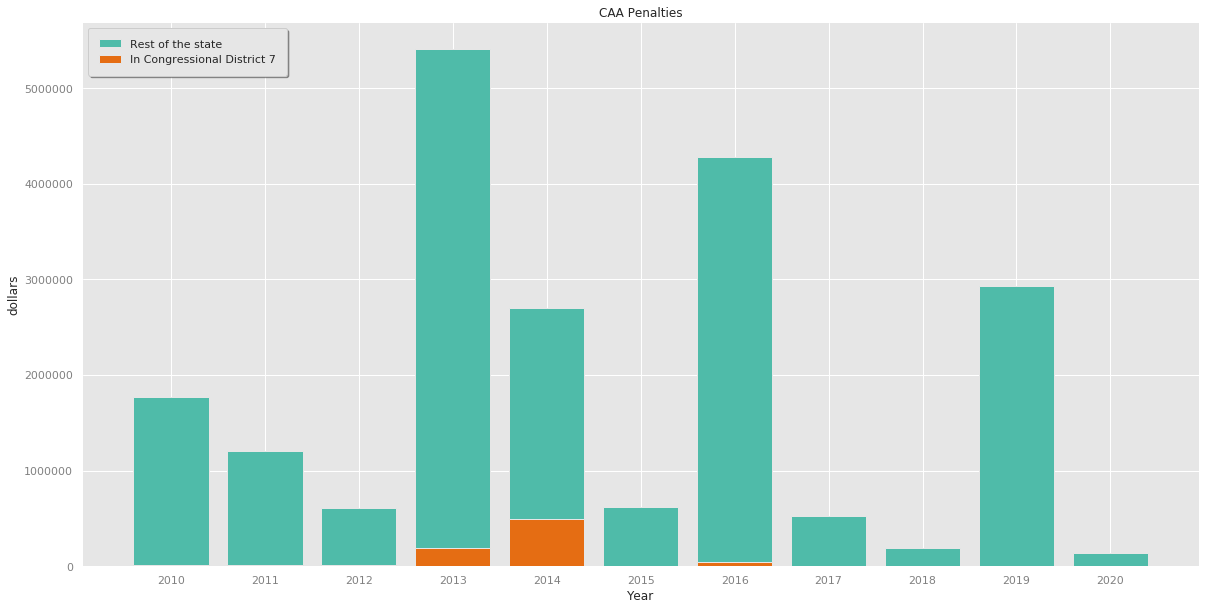

In [42]:
%run ECHO-Sunrise/utilities.py # Load the right style parameters
plt.figure(figsize=(20,10))
plt.bar(bars.index, bars[program.agg_col])
plt.bar(bars.index, bars[program.agg_col + " in this District"])
plt.title(program.name)
plt.xlabel( 'Year' )
plt.ylabel( program.unit )
plt.legend(["Rest of the state", "In %s" %(select_region_widget.value)])
plt.show()   

bars.to_csv("trends-"+program.name+"-MA-"+select_region_widget.value+".csv")

### 6. Rank and map facilities in this district
In the first cell below, we will show the 20 facilities with the most inspections, violations, emissions or penalties (depending on your selection above) in your selected district.

21 facilities have been ranked.


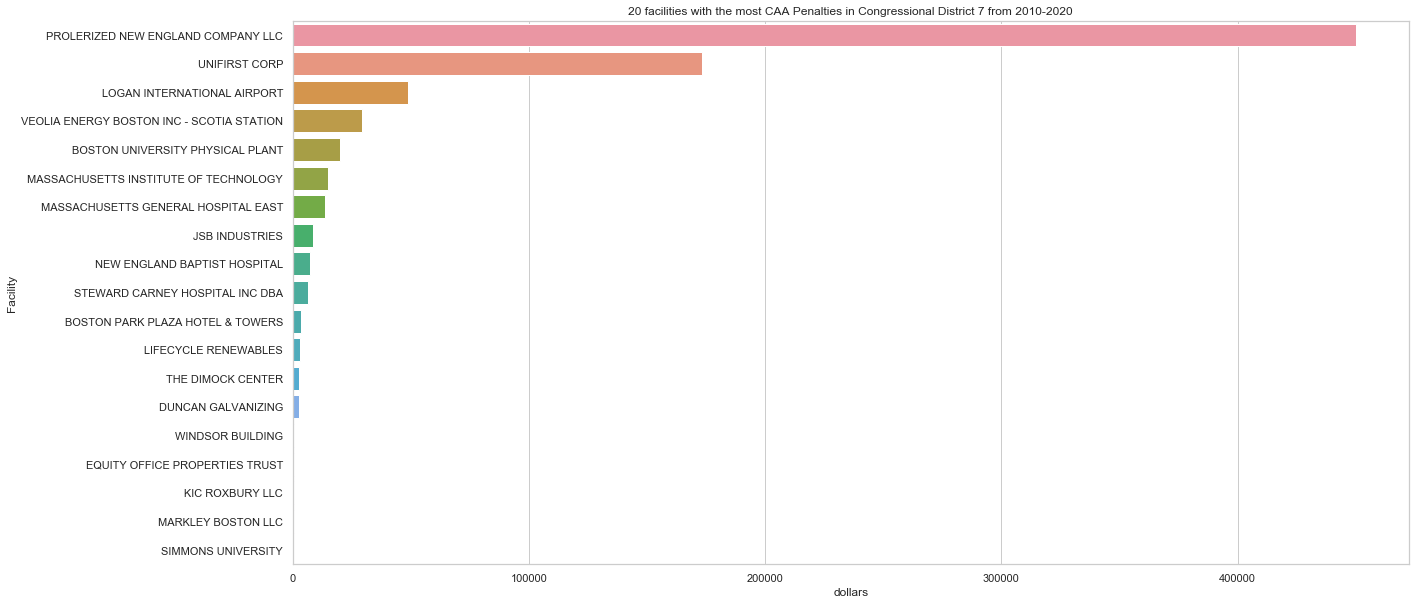

In [43]:
district_program_data.to_csv("district_program_data-"+program.name+"-"+select_region_widget.value+".csv")

if (district_program_data.shape[0] > 0):
    ranked = district_program_data.set_index("Index")
    q_num = 5 if ( len( ranked ) >= 5 ) else int( len( ranked ) / 2 )
    ranked['quantile'] = pd.qcut(ranked[program.agg_col], 5, labels=False, duplicates="drop")
    ranked = ranked.sort_values(by=program.agg_col, ascending=False)
    ranked.to_csv("facilities_ranked-"+program.name+".csv")
    print( "{} facilities have been ranked.".format( len( ranked )))

    time = '2018' if (program.name == "Greenhouse Gas Emissions") else '2020'
    sns.set(style='whitegrid')
    fig, ax = plt.subplots(figsize=(20,10))
    unit = ranked[0:19].index # First 20 rows 
    values = ranked[0:19][program.agg_col] # First 20 rows
    g = sns.barplot(values, unit, order=list(unit), orient="h") 
    g.set_title('20 facilities with the most %s in %s from 2010-%s' %(program.name, select_region_widget.value, time))
    ax.set_xlabel(program.unit)
    ax.set_ylabel("Facility")
    ax.set_yticklabels(ranked[0:19]["FAC_NAME"])
    g
else:
    print("There are no reported emissions/violations/etc. to rank here!")

In this cell, we'll make a map! The little grey dots are all the facilities in this Congressional District regulated under the program you chose. The larger circles are the facilities with inspections, violations, emissions or penalties. Greyed-out circles are facilities that:
- have a record of violations, but not effluent violations (if you are looking at the CWA Violations data set) 
OR 
- have a record of enforcement actions taken against them but no monetary penalties (RCRA Penalties, CAA Penalties, and CWA Penalties data sets)  

In [47]:
if (district_program_data.shape[0] > 0):
    mp = mapper_area(ranked, geo_json_data, program.agg_col, program.unit, program.echo_type,""+program.name+" in "+select_region_widget.value)
    thisdisprogdata=this_district_data.loc[this_district_data[program.echo_type+"_FLAG"] == "Y"]
    for pos,row in thisdisprogdata.iterrows():
        cd = folium.CircleMarker(
          location = [row["FAC_LAT"], row["FAC_LONG"]],
          radius = 3,
          fill_color = "grey",
          weight = .5,
          color = "grey",
          fill_opacity = .75
    ).add_to(mp)
else:
    mp = print("There are no reported emissions/violations/etc. to map here!")
mp

### 7. Accessing your files
Want to download the data tables you created in this notebook? Click on the 'Files' tab in the menu on the left-hand side of the notebook (it looks like a folder). You may have to hit 'Refresh' if you don't see your file. Then, you can click on the ... next to your files and choose "Download". The CSV spreadsheet will download to wherever your browser usually saves files (e.g. Downloads folder)

What's available to download? For _each_ data set you select in step 4 and for _each_ Congressional District you choose in step 2, you will get CSV spreadsheets with:
- trends over time (the bar chart you made in step 5);
- the full data on facilities in this district;
- those facilities ranked (the chart you made in step 6);
You should save each of these!